# What is Grid Search?

"Grid search" is a type of ["hyperparameter optimization"](https://en.wikipedia.org/wiki/Hyperparameter_optimization).

"In the context of machine learning, hyperparameter optimization or model selection is the problem of choosing a set of hyperparameters for a learning algorithm, usually with the goal of optimizing a measure of the algorithm's performance on an independent data set. Often cross-validation is used to estimate this generalization performance.  Hyperparameter optimization contrasts with actual learning problems, which are also often cast as optimization problems, but optimize a loss function on the training set alone. In effect, learning algorithms learn parameters that model/reconstruct their inputs well, while hyperparameter optimization is to ensure the model does not overfit its data by tuning, e.g., regularization." - [wikipedia](https://en.wikipedia.org/wiki/Hyperparameter_optimization)

![](files/gridsearch_cv.png)
(image from [here](https://cambridgecoding.files.wordpress.com/2016/03/gridsearch_cv.png))

In "Grid Search" sets of parameters, each defining a model, are chosen.  Then, for each set of parameters, the model is trained and evaluated (ideally using cross validation to avoid overfitting) using some evaluation metric (e.g., accuracy).  Once all models are evaluated, a "best" or "optimal" set of parameters, and thus an optimal model, can be chosen.

As combinations of parameters can grow quickly with the number of parameters in a model, the computational effort needed to explore a parameter space can be significant.  However, the grid search problem is easily distributed as each model can be evaluated independent of the others.

# Grid Search in Pachyderm

Implementing grid search in pachyderm has the following advantages:

1. Pipeline stages are containerized, so models can be switched in an out from any language as long as they can work on the defined parameter space.  Thus, different models and even models implemented in different languages or packages can be quickly evaluated without have deploy extra infrastructure or dependencies.

2. You can write your model in a simple serial implementation (e.g., with scikit learn), while still easily distributing that simple model over many different sets of parameters.

3. When you incrementally make changes to your parameters space, pachyderm will automatically and incrementally update the analysis such that all cases need not be evaluate again.

## Pipeline Overview

![](files/pachyderm_grid_search.jpg)

The PFS and PPS components that enable simple, distributed grid search are:

- `paramranges` repo - includes a json document specifying a number of parameters and ranges associated with each of those parameters.
- `filter` pipeline - expands all combinations of those parameters and stores each combination in an output file in the `filter` repo.
- `evaluate` pipeline - evaluates each model (as defined by each set of parameters) on a set of data included in the `training` repo using cross validation.
- `evaluate` repo - the output of the `evaluate` pipeline containing the evaluation metrics for each set of parameters.

The pipeline manifest that powers the above flow is as follows:

    {
      "pipeline": {
        "name": "filter"
      },
      "transform": {
        "image": "dwhitena/paramfilter",
        "cmd": [ "/paramfilter" ],
        "stdin": []
      },
      "inputs": [
        {
          "repo": {
            "name": "paramranges"
          },
          "method": "map"
        }
      ]
    }
    {
      "pipeline": {
        "name": "evaluate"
      },
      "transform": {
        "image": "dwhitena/modeleval",
        "cmd": [ "python", "/modeleval.py" ],
        "stdin": []
      },
      "inputs": [
        {
          "repo": {
            "name": "filter"
          },
          "method": "map"
        },
        {
          "repo": {
            "name": "training"
          },
          "method": "global"
        }
      ]
    }

## Input Data

### Example parameter ranges (stored in the `paramranges` repo)

    [
        {
            "name": "n_estimators",
            "Min": 1,
            "Max": 500,
            "Increment": 20
        },
        {
            "name": "max_features",
            "Min": 2,
            "Max": 11,
            "Increment": 1
        }
    ]

### Example training data (used for training and cross validation)

This evaluation pipeline could be used for any sort of model over any parameter space, including classification models, regression models, etc.  However, by way of example, we will consider a random forest model attempting to predict wine quality from a data points representing chemical properties of various wines.  This data set can be found [here](http://archive.ics.uci.edu/ml/datasets/Wine+Quality) and looks like:

    "fixed acidity";"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"
    7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5
    7.8;0.88;0;2.6;0.098;25;67;0.9968;3.2;0.68;9.8;5
    7.8;0.76;0.04;2.3;0.092;15;54;0.997;3.26;0.65;9.8;5
    11.2;0.28;0.56;1.9;0.075;17;60;0.998;3.16;0.58;9.8;6
    7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5
    7.4;0.66;0;1.8;0.075;13;40;0.9978;3.51;0.56;9.4;5
    7.9;0.6;0.06;1.6;0.069;15;59;0.9964;3.3;0.46;9.4;5
    7.3;0.65;0;1.2;0.065;15;21;0.9946;3.39;0.47;10;7
    7.8;0.58;0.02;2;0.073;9;18;0.9968;3.36;0.57;9.5;7

## Output Data

The output of the pipelines will be a file called `results.csv` that includes all pairs of paramaters sets with corresponding evaluation metrics (e.g., accuracies).  Again, any evaluation metric can be used and changed with a simple change to the containers utilized in the pipeline.  The output will look something like:

    {"n_estimators": 1.00, "max_features": 10.00}, 0.486055376255
    {"n_estimators": 1.00, "max_features": 11.00}, 0.453946143819
    {"n_estimators": 1.00, "max_features": 2.00}, 0.442220695804
    {"n_estimators": 1.00, "max_features": 3.00}, 0.476594469437
    {"n_estimators": 1.00, "max_features": 4.00}, 0.471664247368
    {"n_estimators": 1.00, "max_features": 5.00}, 0.467147413542
    {"n_estimators": 1.00, "max_features": 6.00}, 0.450757703385
    {"n_estimators": 1.00, "max_features": 7.00}, 0.490742069559
    {"n_estimators": 1.00, "max_features": 8.00}, 0.451532999852
    {"n_estimators": 1.00, "max_features": 9.00}, 0.466515994985
    {"n_estimators": 11.00, "max_features": 10.00}, 0.533487838961
    {"n_estimators": 11.00, "max_features": 11.00}, 0.534702031476
    {"n_estimators": 11.00, "max_features": 2.00}, 0.556163495182
    {"n_estimators": 11.00, "max_features": 3.00}, 0.53033896664
    {"n_estimators": 11.00, "max_features": 4.00}, 0.531569892182
    {"n_estimators": 11.00, "max_features": 5.00}, 0.532986352317

For the case of the random forest model and the wine quality data, an example run of the pipelines ranging `n_estimators` from 0 to 500 and `max_features` from 2 to 11 (two parameters in scikit-learn's implementation of the random forest classification algorithm) produced the following output:

In [1]:
import pandas as pd
df = pd.read_csv("files/example_output.csv", names=["n_estimators", "max_features", "accuracy"])
df['n_estimators'] = df['n_estimators'].map(lambda x: int(float(x[16:])))
df['max_features'] = df['max_features'].map(lambda x: int(float(x[16:-1])))

In [2]:
df.head()

,n_estimators,max_features,accuracy
0,1,10,0.472356
1,1,11,0.420230
2,1,2,0.461088
3,1,3,0.467179
4,1,4,0.476044


We can then easily find the optimal set of parameters along with the best accuracy we can expect in classifying wine qualities:

In [3]:
df[df['accuracy'] == df['accuracy'].max()]

,n_estimators,max_features,accuracy
103,261,3,0.586743


And the accuracies corresponding the whole of the parameter space can be visualized:

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import pylab
import numpy as np
pylab.rcParams['figure.figsize'] = (12.0, 10.0)

p1_len = len(df['n_estimators'].unique())
p2_len = len(df['max_features'].unique())
heatmat = np.empty([p1_len, p2_len])

dfmod = df.set_index(["n_estimators", "max_features"])
for i in range(1,5):
    for j in range(1,10):
        heatmat[i, j] = dfmod.ix[df['n_estimators'].unique()[i], df['max_features'].unique()[j]]['accuracy'].mean()

(1, 5)

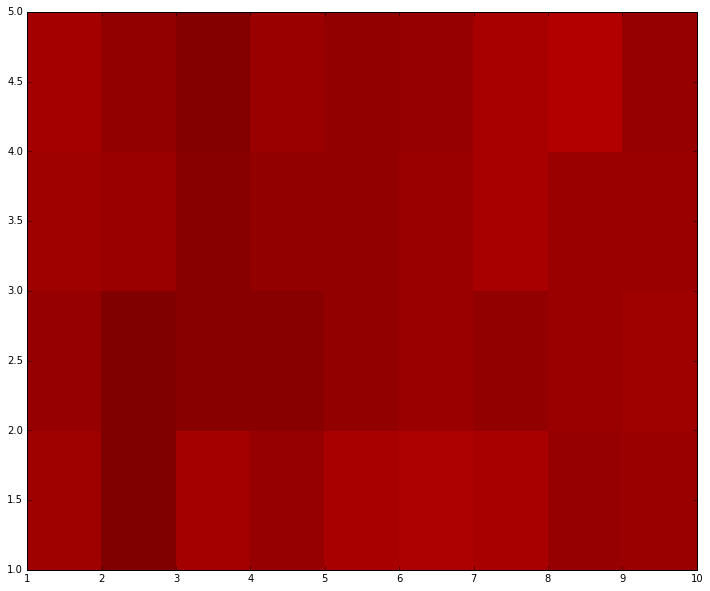

In [5]:
plt.pcolor(heatmat)
plt.xlim([1,10])
plt.ylim([1,5])